# 📝 Exercise M2.01

The aim of this exercise is to make the following experiments:

* train and test a support vector machine classifier through
  cross-validation;
* study the effect of the parameter gamma of this classifier using a
  validation curve;
* study if it would be useful in term of classification if we could add new
  samples in the dataset using a learning curve.

To make these experiments we will first load the blood transfusion dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [6]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

print("Number of samples blood transfusion: {}".format(len(target)))

Number of samples blood transfusion: 748


We will use a support vector machine classifier (SVM). In its most simple
form, a SVM classifier is a linear classifier behaving similarly to a
logistic regression. Indeed, the optimization used to find the optimal
weights of the linear model are different but we don't need to know these
details for the exercise.

Also, this classifier can become more flexible/expressive by using a
so-called kernel making the model becomes non-linear. Again, no requirement
regarding the mathematics is required to accomplish this exercise.

We will use an RBF kernel where a parameter `gamma` allows to tune the
flexibility of the model. See more on information on the `gamma` parameter at https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

First let's create a predictive pipeline made of:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  where the parameter `kernel` could be set to `"rbf"`. Note that this is the
  default.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

modelp = make_pipeline(StandardScaler(), SVC())

Evaluate the statistical performance of your model by cross-validation with a
`ShuffleSplit` scheme. Thus, you can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
and pass a [`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit`
and let the other parameters to the default.

In [8]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

cv = ShuffleSplit(random_state=0)
cv_result = cross_validate(modelp, data, target, cv=cv)

In [9]:
pd.DataFrame(cv_result)

,fit_time,score_time,test_score
0,0.015674,0.002374,0.680000
1,0.013265,0.002304,0.746667
2,0.013885,0.002442,0.786667
3,0.013294,0.002372,0.800000
4,0.013959,0.002334,0.746667
5,0.013545,0.002337,0.786667
6,0.013319,0.002289,0.800000
7,0.012589,0.002316,0.826667
8,0.013046,0.002310,0.746667
9,0.013093,0.002330,0.733333


As previously mentioned, the parameter `gamma` is one of the parameter
controlling under/over-fitting in support vector machine with an RBF kernel.

Compute the validation curve
(using [`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html))
to evaluate the effect of the parameter `gamma`. You can vary its value
between `10e-3` and `10e2` by generating samples on a logarithmic scale.
Thus, you can use `np.logspace(-3, 2, num=30)`.

Since we are manipulating a `Pipeline` the parameter name will be set to
`svc__gamma` instead of only `gamma`. You can retrieve the parameter name
using `model.get_params().keys()`. We will go more into details regarding
accessing and setting hyperparameter in the next section.

In [27]:
modelp.get_params().items()

dict_items([('memory', None), ('steps', [('standardscaler', StandardScaler()), ('svc', SVC())]), ('verbose', False), ('standardscaler', StandardScaler()), ('svc', SVC()), ('standardscaler__copy', True), ('standardscaler__with_mean', True), ('standardscaler__with_std', True), ('svc__C', 1.0), ('svc__break_ties', False), ('svc__cache_size', 200), ('svc__class_weight', None), ('svc__coef0', 0.0), ('svc__decision_function_shape', 'ovr'), ('svc__degree', 3), ('svc__gamma', 'scale'), ('svc__kernel', 'rbf'), ('svc__max_iter', -1), ('svc__probability', False), ('svc__random_state', None), ('svc__shrinking', True), ('svc__tol', 0.001), ('svc__verbose', False)])

Plot the validation curve for the train and test scores.

In [11]:
import numpy as np
gamma_range = np.logspace(-1, 1, num=21)

In [24]:
%%time
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
                                    modelp, 
                                    data, 
                                    target, 
                                    param_name='svc__gamma', 
                                    param_range=gamma_range,
                                    cv=cv)

CPU times: user 6.02 s, sys: 0 ns, total: 6.02 s
Wall time: 6.02 s


Text(0.5, 1.0, 'Validation curve for SVM RBF kernel')

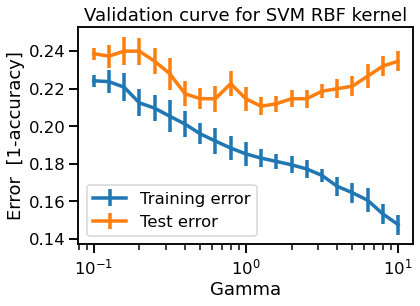

In [31]:
import matplotlib.pyplot as plt

plt.errorbar(gamma_range, 1.-train_scores.mean(axis=1), yerr=(1.-train_scores).std(axis=1), label='Training error')
plt.errorbar(gamma_range, 1.-test_scores.mean(axis=1), yerr=(1.-train_scores).std(axis=1), label='Test error')
plt.xscale('log')
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Error  [1-accuracy]')
plt.title("Validation curve for SVM RBF kernel")

Optimal Gamma is around Gamma=1.
Hmmm. How can the error be negative?

Now, you can perform an analysis to check whether adding new samples to the
dataset could help our model to better generalize. Compute the learning curve
(using [`sklearn.model_selection.learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html))
by computing the train and test scores for different training dataset size.
Plot the train and test scores with respect to the number of samples.

In [36]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

modelp2 = make_pipeline(StandardScaler(), SVC(gamma=1.))
lcurve_results = learning_curve(modelp2, data, target, train_sizes=train_sizes, cv=cv, )
train_size, train_scores, test_scores = lcurve_results[:3]

# Convert the scores into errors
train_errors, test_errors = 1.-train_scores, 1.-test_scores

Text(0.5, 1.0, 'Training curve for SVM RBF kernel')

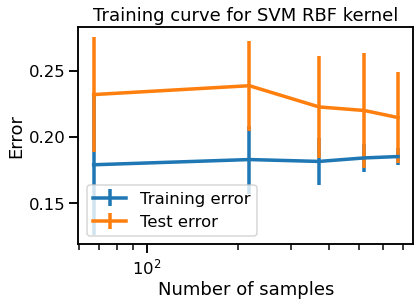

In [37]:
plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training error")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Test error")
plt.legend()

plt.xscale("log")

plt.xlabel("Number of samples")
plt.ylabel("Error")
plt.title("Training curve for SVM RBF kernel")